In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

/home/xavient/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xavient/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xavient/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xavient/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

###### Using the data that was cleaned and persisted while building the ML model.

In [6]:
data = pd.read_csv('./cleanedData.csv')

In [7]:
data.head()

,tweet_id,sentiment,text,clean_tweet,clean_tweet2
0,1,neutral,What @dhepburn said.,What said.,what said
1,2,positive,plus you've added commercials to the experienc...,plus you have added commercials to the experie...,plus added commercial experience tacky
2,3,neutral,I didn't today... Must mean I need to take ano...,I did not today... Must mean I need to take an...,did not today must mean need take another trip
3,4,negative,"it's really aggressive to blast obnoxious ""ent...","it is really aggressive to blast obnoxious ""en...",really aggressive blast obnoxious entertainmen...
4,5,negative,and it's a really big bad thing about it,and it is a really big bad thing about it,really big bad thing about


In [8]:
# Tokenize the sentences
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(data.clean_tweet)

# max length(number of words) that a tweet has
max_len = max([len(x.split()) for x in data.clean_tweet])

# The word vocabulary that has been discovered after tekenizing the tweets
vocab_size = len(tokenizer_obj.word_index) + 1

# Replacing words by their indexes in the vocabulary
dataTokenized = tokenizer_obj.texts_to_sequences(data.clean_tweet)

# Padding the sequences to get an equal length for all sequences as they are to be fed to a model which expects a matrix
dataTokenizedPadded = pad_sequences(dataTokenized, maxlen=max_len, padding="post")

In [9]:
dataTokenizedPadded.shape

(14608, 35)

In [10]:
# We are using the pretrained Google News vectors as Word2Vex model
word_vectors = KeyedVectors.load_word2vec_format('../NLP_Case_Study/GoogleNews-vectors-negative300.bin', binary=True)

In [11]:
word_index = tokenizer_obj.word_index

In [12]:
len(word_index)

13203

In [13]:
word_index

{'to': 1,
 'the': 2,
 'i': 3,
 'a': 4,
 'is': 5,
 'you': 6,
 'for': 7,
 'flight': 8,
 'on': 9,
 'and': 10,
 'not': 11,
 'my': 12,
 'in': 13,
 'it': 14,
 'have': 15,
 'of': 16,
 'me': 17,
 'your': 18,
 'that': 19,
 'was': 20,
 'with': 21,
 'no': 22,
 'at': 23,
 'this': 24,
 'do': 25,
 'get': 26,
 'but': 27,
 'be': 28,
 'from': 29,
 'are': 30,
 'we': 31,
 'can': 32,
 'thanks': 33,
 'cancelled': 34,
 'now': 35,
 'an': 36,
 'just': 37,
 'service': 38,
 'so': 39,
 '2': 40,
 'help': 41,
 'been': 42,
 'what': 43,
 'time': 44,
 'will': 45,
 'customer': 46,
 'up': 47,
 'out': 48,
 'they': 49,
 'our': 50,
 "i'm": 51,
 'amp': 52,
 'hours': 53,
 'us': 54,
 'how': 55,
 'when': 56,
 'flights': 57,
 'hold': 58,
 'plane': 59,
 'there': 60,
 'if': 61,
 'all': 62,
 'would': 63,
 'thank': 64,
 'why': 65,
 'still': 66,
 'one': 67,
 'please': 68,
 'need': 69,
 'delayed': 70,
 'ca': 71,
 'did': 72,
 'back': 73,
 'gate': 74,
 'had': 75,
 'call': 76,
 'about': 77,
 'flightled': 78,
 'has': 79,
 'bag': 80,
 'o

In [14]:
# The dimensions of the word vectors that have been used
EMBEDDING_DIM = 300

# num_words in the vocabulary
num_words = len(word_index) + 1

# Creating an embedding matrix containg 0s as embedding for all the words in the vocabulary
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# Filling in the actual embeddings from the words
for word, i in word_index.items():
    if(i > num_words):
        continue
    if(word in word_vectors):
        embedding_vector = word_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [15]:
# Creating a model architecture

from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, RNN
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

# This is a sequential model
model = Sequential()

# Create and add an embedding layer to the model, which has word embeddings data
embedding_layer = Embedding(num_words, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), input_length=max_len,
                           trainable = False)
model.add(embedding_layer)

# Using an LSTM architecture with 32 units of LSTM cell. Using dropout for regularisation.
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))

# The final layer having 3 outputs for negative, neutral and positive output and sigmoid activation function.
model.add(Dense(3, activation='sigmoid'))

# Compiling the model with all the layers added above
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [16]:
dataTokenizedPadded.shape, data.shape

((14608, 35), (14608, 5))

In [17]:
# Converting the target variable to one hot vectors to get 3 outputs as is required by the model
y = pd.get_dummies(data.sentiment)


In [18]:
# Splitting to train and test data
X_train_pad, X_test_pad, Y_train, Y_test = train_test_split(dataTokenizedPadded, y,
                                                           test_size = 0.2, stratify = data.sentiment)

In [19]:
X_train_pad.shape, Y_train.shape, X_test_pad.shape, Y_test.shape

((11686, 35), (11686, 3), (2922, 35), (2922, 3))

In [20]:
# Fitting the model. We can use Model Check points to save the best performing model and early stoppng to stop at a point where there is no significant improve further.

history = model.fit(X_train_pad, Y_train, batch_size = 128, epochs = 25, validation_data=(X_test_pad, Y_test), verbose=2, )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 11686 samples, validate on 2922 samples
Epoch 1/25
 - 5s - loss: 0.9093 - acc: 0.6234 - val_loss: 0.8042 - val_acc: 0.6314
Epoch 2/25
 - 3s - loss: 0.7610 - acc: 0.6681 - val_loss: 0.7166 - val_acc: 0.7026
Epoch 3/25
 - 3s - loss: 0.6972 - acc: 0.6971 - val_loss: 0.6711 - val_acc: 0.7153
Epoch 4/25
 - 4s - loss: 0.6682 - acc: 0.7102 - val_loss: 0.6442 - val_acc: 0.7303
Epoch 5/25
 - 4s - loss: 0.6424 - acc: 0.7282 - val_loss: 0.6301 - val_acc: 0.7348
Epoch 6/25
 - 4s - loss: 0.6207 - acc: 0.7425 - val_loss: 0.6062 - val_acc: 0.7543
Epoch 7/25
 - 4s - loss: 0.5991 - acc: 0.7602 - val_loss: 0.5974 - val_acc: 0.7611
Epoch 8/25
 - 4s - loss: 0.5729 - acc: 0.7721 - val_loss: 0.5957 - val_acc: 0.7598
Epoch 9/25
 - 3s - loss: 0.5554 - acc: 0.7781 - val_loss: 0.5560 - val_acc: 0.7765
Epoch 10/25
 - 3s - loss: 0.5412 - acc: 0.7854 - val_loss: 0.5554 - val_acc: 0.7786
Epoch 11/25
 - 3s - loss: 

In [21]:
# Plotting the model performance

from matplotlib import pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()


<Figure size 640x480 with 1 Axes>

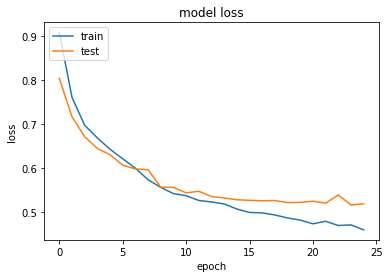

In [22]:
# Plotting the model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [23]:
preds = model.predict_classes(X_test_pad)

In [24]:
preds

array([0, 2, 2, ..., 0, 0, 0])

In [25]:
# Label encoding the target variable to calculate f1 score and other parameters
lbl_enc = LabelEncoder()
data['label'] = lbl_enc.fit_transform(data.sentiment)

In [26]:
# Plotting the confusion matrix using actual labels and predicted labels
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(data.iloc[Y_test.index].label, preds)

array([[1685,  102,   48],
       [ 227,  331,   57],
       [  95,   52,  325]])

In [27]:
print(classification_report(data.iloc[Y_test.index].label, preds))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1835
           1       0.68      0.54      0.60       615
           2       0.76      0.69      0.72       472

    accuracy                           0.80      2922
   macro avg       0.76      0.72      0.73      2922
weighted avg       0.79      0.80      0.79      2922



###### The model has an f1 score of 0.81. We can tune the threshold based on the requirement of Precision, Recall parameters and use AUC-ROC curve to come to a optimal threshold value